In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import ast
from itertools import chain
from collections import Counter
pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
tf.random.set_seed(50)
np.random.seed(50)

c:\Users\artkr\anaconda3\New folder\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
df = pd.read_csv("data/full_set.csv")

In [3]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]


final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]

groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

In [4]:
train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

(9424, 355) (1178, 355) (1179, 355)


In [5]:
# Create pass/fail column
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    return 0 if grade in fail_grades else 1  # 0 = fail, 1 = pass

#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered = groupped_df_filtered.set_index('Pidm')
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

# Apply the function to create pass/fail column
train_set['pass_fail'] = train_set['Target_Grade'].apply(map_pass_fail)
dev_set['pass_fail'] = dev_set['Target_Grade'].apply(map_pass_fail)

# # Drop irrelevant columns
X = train_set.drop(columns=['Target_Grade', 'pass_fail'])
X_dev = dev_set.drop(columns=['Target_Grade', 'pass_fail'])

# Convert all remaining object columns to numeric
# X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, 'pass_fail']
y_dev = dev_set.loc[X_dev.index, 'pass_fail']

In [6]:
counts = train_set['pass_fail'].value_counts()
counts.get(1, 1)
print(counts.get(0, 0))
print(counts.get(1, 1))

1122
8302


In [8]:
sample_count = min(counts.get(0, 0), counts.get(1, 1))

pass_class = X[y == 1]
fail_class = X[y == 0]

pass_sample = resample(pass_class, replace=False, n_samples=sample_count, random_state=50)
fail_sample = resample(fail_class, replace=False, n_samples=sample_count, random_state=50)

# Combine the undersampled data
X_undersampled = pd.concat([pass_sample, fail_sample])
y_undersampled = pd.concat([y[pass_sample.index], y[fail_sample.index]])

X_train = X_undersampled
X_test = X_dev
y_train = y_undersampled
y_test = y_dev

## 2layers + dropout

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dropout(0.1),  # Dropout layer to reduce overfitting
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
71/71 [==============================] - 1s 5ms/step - loss: 8.5438 - accuracy: 0.5187
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 3.6848 - accuracy: 0.5022
Epoch 3/50
71/71 [==============================] - 0s 4ms/step - loss: 1.8550 - accuracy: 0.5307
Epoch 4/50
71/71 [==============================] - 0s 4ms/step - loss: 1.2784 - accuracy: 0.5374
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.9819 - accuracy: 0.5731
Epoch 6/50
71/71 [==============================] - 0s 4ms/step - loss: 0.8983 - accuracy: 0.5646
Epoch 7/50
71/71 [==============================] - 0s 4ms/step - loss: 0.8330 - accuracy: 0.5735
Epoch 8/50
71/71 [==============================] - 0s 4ms/step - loss: 0.7998 - accuracy: 0.5838
Epoch 9/50
71/71 [==============================] - 0s 4ms/step - loss: 0.8072 - accuracy: 0.5646
Epoch 10/50
71/71 [==============================] - 0s 4ms/step - loss: 0.7107 - accuracy: 0.6239
Epoch 11/50
71/71 [

37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.22      0.51      0.31       152
     Class 1       0.91      0.73      0.81      1026

    accuracy                           0.71      1178
   macro avg       0.57      0.62      0.56      1178
weighted avg       0.82      0.71      0.75      1178



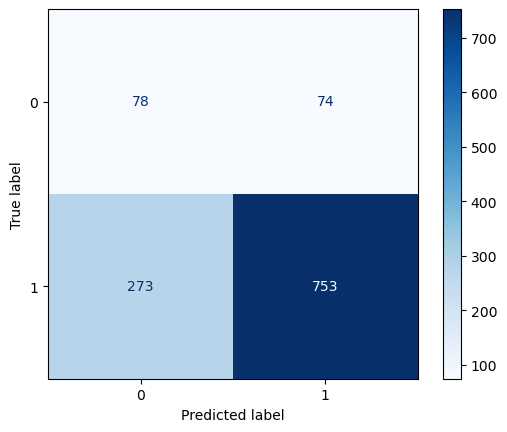

In [29]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

y_pred_probs = model.predict(X_test)
# Convert probabilities to binary outputs (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))
conf_matrix = confusion_matrix(y_test, y_pred)

# Optionally, you can use a visual representation (if running in a notebook environment)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')

## 2layers

In [41]:
checkpoint = ModelCheckpoint(
    "2_layers_models.h5", 
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)

model = load_model("2_layers_models.h5")

Epoch 1/50
63/71 [=========================>....] - ETA: 0s - loss: 3.9097 - accuracy: 0.4886
Epoch 1: accuracy improved from -inf to 0.48841, saving model to 2_layers_models.h5
71/71 [==============================] - 1s 13ms/step - loss: 3.5887 - accuracy: 0.4884 - val_loss: 0.5601 - val_accuracy: 0.7674
Epoch 2/50
69/71 [============================>.] - ETA: 0s - loss: 0.7103 - accuracy: 0.5340
Epoch 2: accuracy improved from 0.48841 to 0.53521, saving model to 2_layers_models.h5
71/71 [==============================] - 0s 7ms/step - loss: 0.7097 - accuracy: 0.5352 - val_loss: 0.5861 - val_accuracy: 0.7097
Epoch 3/50
55/71 [======================>.......] - ETA: 0s - loss: 0.7435 - accuracy: 0.5330
Epoch 3: accuracy improved from 0.53521 to 0.55036, saving model to 2_layers_models.h5
71/71 [==============================] - 0s 5ms/step - loss: 0.7258 - accuracy: 0.5504 - val_loss: 0.4089 - val_accuracy: 0.8616
Epoch 4/50
64/71 [==========================>...] - ETA: 0s - loss: 0.72

37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.21      0.53      0.30       152
     Class 1       0.91      0.71      0.80      1026

    accuracy                           0.69      1178
   macro avg       0.56      0.62      0.55      1178
weighted avg       0.82      0.69      0.73      1178



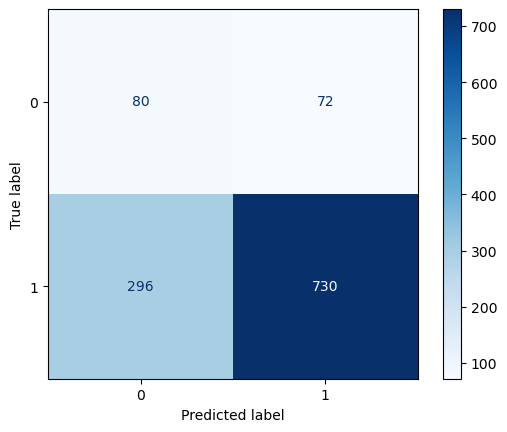

In [42]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

y_pred_probs = model.predict(X_test)
# Convert probabilities to binary outputs (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))
conf_matrix = confusion_matrix(y_test, y_pred)

# Optionally, you can use a visual representation (if running in a notebook environment)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')

## 1 layer

In [49]:
checkpoint = ModelCheckpoint(
    "2_layers_models.h5", 
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)

model = load_model("2_layers_models.h5")

Epoch 1/50
68/71 [===========================>..] - ETA: 0s - loss: 5.6886 - accuracy: 0.4775
Epoch 1: accuracy improved from -inf to 0.47772, saving model to 2_layers_models.h5
71/71 [==============================] - 2s 15ms/step - loss: 5.5489 - accuracy: 0.4777 - val_loss: 1.2795 - val_accuracy: 0.3879
Epoch 2/50
70/71 [============================>.] - ETA: 0s - loss: 0.8656 - accuracy: 0.5312
Epoch 2: accuracy improved from 0.47772 to 0.53119, saving model to 2_layers_models.h5
71/71 [==============================] - 0s 6ms/step - loss: 0.8665 - accuracy: 0.5312 - val_loss: 0.5106 - val_accuracy: 0.7547
Epoch 3/50
66/71 [==========================>...] - ETA: 0s - loss: 0.8082 - accuracy: 0.5833
Epoch 3: accuracy improved from 0.53119 to 0.58690, saving model to 2_layers_models.h5
71/71 [==============================] - 0s 7ms/step - loss: 0.7945 - accuracy: 0.5869 - val_loss: 0.3851 - val_accuracy: 0.8557
Epoch 4/50
68/71 [===========================>..] - ETA: 0s - loss: 0.94

37/37 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.26      0.38      0.31       152
     Class 1       0.90      0.84      0.87      1026

    accuracy                           0.78      1178
   macro avg       0.58      0.61      0.59      1178
weighted avg       0.82      0.78      0.79      1178



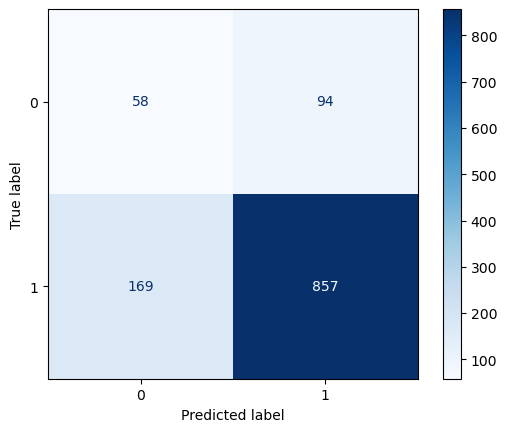

In [50]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

y_pred_probs = model.predict(X_test)
# Convert probabilities to binary outputs (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))
conf_matrix = confusion_matrix(y_test, y_pred)

# Optionally, you can use a visual representation (if running in a notebook environment)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')

## Hyperparam tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(357,)))  # Input layer
    
    # Add a dense hidden layer with varying number of neurons and activation function
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),  # Search over 32, 64, 96, 128 units
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    ))
    
    # Add a dropout layer with varying dropout rates
    model.add(tf.keras.layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2])))
    
    # Output layer for binary classification
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate a tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best number of units: {best_hps.get('units')}
Best activation: {best_hps.get('activation')}
Best dropout rate: {best_hps.get('dropout_rate')}
Best learning rate: {best_hps.get('learning_rate')}
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))



Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.8701188564300537

Best val_accuracy So Far: 0.8709677457809448
Total elapsed time: 00h 01m 52s

Best number of units: 32
Best activation: relu
Best dropout rate: 0.0
Best learning rate: 0.1

Epoch 1/30
71/71 [==============================] - 1s 8ms/step - loss: 8.7684 - accuracy: 0.5036 - val_loss: 0.6726 - val_accuracy: 0.8710
Epoch 2/30
71/71 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4831 - val_loss: 0.7069 - val_accuracy: 0.1290
Epoch 3/30
71/71 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4750 - val_loss: 0.6613 - val_accuracy: 0.8710
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4831 - val_loss: 0.7078 - val_accuracy: 0.1290
Epoch 5/30
71/71 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.4982 - val_loss: 0.6450 - val_accuracy: 0.8710
Epoch 6/30
71/71 [==============================] - 0s 4ms/st

In [152]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5631 - accuracy: 0.7130
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.7193
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5795 - accuracy: 0.6912
Epoch 4/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5788 - accuracy: 0.6934
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5475 - accuracy: 0.7282
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5518 - accuracy: 0.7268
Epoch 7/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5441 - accuracy: 0.7286
Epoch 8/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.7126
Epoch 9/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5369 - accuracy: 0.7210
Epoch 10/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5394 - accuracy: 0.7201
Epoch 11/50
71/71 [

In [13]:
loss, accuracy = best_model.evaluate(X_test, y_test, batch_size=32)

37/37 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.1290


37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.13      1.00      0.23       152
     Class 1       0.00      0.00      0.00      1026

    accuracy                           0.13      1178
   macro avg       0.06      0.50      0.11      1178
weighted avg       0.02      0.13      0.03      1178



c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


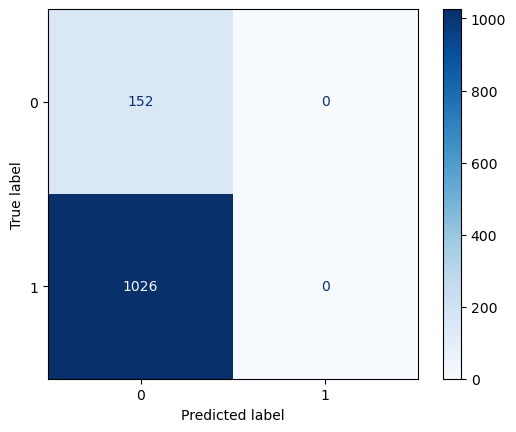